# Data modelling on Bike Sharing data in London

Data aquired from: https://s3.amazonaws.com/capitalbikeshare-data/index.html  
Data project initiated: 25/01/2019  
Author: Sedar Olmez

Data modelling:  
    GDS1: Data Gathering, Preparation and Exploration.  
    GDS2: Data Representation and Transformation.  
    GDS3: Computing with Data.   
    GDS4: Data Visualisation and Presentation.   
    GDS5: Data Modelling.   
    GDS6: Science about Data Science. 

Assessment:
![Assessment](assessment.png)

# Dataset information
I have two datasets, one I will be using to clean and the other to perform machine learning algorithms on. The reason for why I am using two is because the original dataset I want to use has already been cleaned, therefore, I need to perform some cleaning tasks on a smaller dataset with a similar theme.

1) Dataset (cleaning): Walking_Cycling.csv - London Cycling % and Walking % by Local Authority `COLUMNS: 'LA code', 'Local Authority', 'Year', 'Frequency', 'Walking_%', 'Cycling_%'`


2) Dataset (Machine Learning/visualisation): capitalbikeshare-tripdata-washington.csv - Capital Bike sharing information in Washington DC 2017, large dataset with a lot of useful data. `COLUMNS: 'Duration'	'Start Date'	'End Date'	'Start Station Number'	'Start Station Name'	'End Station Number'	'End Station Name'	'Bike Number'	'Member Type'`

In [1]:
# Libraries
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sea
import pandas as pd
import numpy as np
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor as DTR

## Small dataset - Walking_Cycling.csv

In [2]:
%%time
# Load up the journeys.csv dataset into dataframes
dataframe_journeys = pd.read_csv('data/Walking-Cycling.csv')
dataframe_journeys.columns = ['LA code', 'Local Authority', 'Year', 'Frequency', 'Walking_%', 'Cycling_%']
dataframe_journeys.dropna()

CPU times: user 7.44 ms, sys: 3.88 ms, total: 11.3 ms
Wall time: 29.8 ms


In [3]:
dataframe_journeys.head()

,LA code,Local Authority,Year,Frequency,Walking_%,Cycling_%
0,E09000001,City of London,2010/11,1x per month,78,30
1,E09000002,Barking and Dagenham,2010/11,1x per month,60,8
2,E09000003,Barnet,2010/11,1x per month,65,10
3,E09000004,Bexley,2010/11,1x per month,65,11
4,E09000005,Brent,2010/11,1x per month,62,14


In [4]:
list(dataframe_journeys)

['LA code', 'Local Authority', 'Year', 'Frequency', 'Walking_%', 'Cycling_%']

In [5]:
# We will now convert the Local Authority column to string
dataframe_journeys['Local Authority'] = dataframe_journeys['Local Authority'].astype('|S')

In [6]:
dataframe_journeys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 6 columns):
LA code            1204 non-null object
Local Authority    1204 non-null object
Year               1204 non-null object
Frequency          1204 non-null object
Walking_%          1204 non-null int64
Cycling_%          1204 non-null object
dtypes: int64(1), object(5)
memory usage: 56.5+ KB


#### In Pandas, dtype(obj) == python.dtype(str) therefore we set the string to the maximum bytes of the longest string stored by using

```.astype(|S)```

In [8]:
# We must now convert both the Walking_% and Cycling_% to float as this would make regression more accurate.
# However we must first convert Cycling_% from String to Int then Float.
dataframe_journeys['Cycling_%'].astype(int)

ValueError: invalid literal for long() with base 10: '-'

In [9]:
# An invalit literal for long() error is thrown, this means there are values in the column which cannot be converted to int
# Let us identify these columns
dataframe_journeys['Cycling_%'] = pd.to_numeric(dataframe_journeys['Cycling_%'], errors='coerce')

In [10]:
# We found the row with the problem, for row 326 the column Cycling_% had '-' so we replaced it with NaN.
print (dataframe_journeys[ pd.to_numeric(dataframe_journeys['Cycling_%'], errors='coerce').isnull()])

       LA code Local Authority     Year    Frequency  Walking_%  Cycling_%
326  E09000026       Redbridge  2011/12  5x per week         17        NaN


In [11]:
# We must replace the NaN to an integer value i.e. 0 so we can produce a pairplot later using seaborn.
dataframe_journeys = dataframe_journeys.fillna(0.0)

In [12]:
# The 'Cycling_%' column was converted to int, now we can focus on changing both columns to floats.
dataframe_journeys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 6 columns):
LA code            1204 non-null object
Local Authority    1204 non-null object
Year               1204 non-null object
Frequency          1204 non-null object
Walking_%          1204 non-null int64
Cycling_%          1204 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 56.5+ KB


In [13]:
# Here we convert Walking_% to float from int
dataframe_journeys['Walking_%'] = dataframe_journeys['Walking_%'].astype(float)

In [14]:
# As can be seen, we converted the columns to floats.
dataframe_journeys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 6 columns):
LA code            1204 non-null object
Local Authority    1204 non-null object
Year               1204 non-null object
Frequency          1204 non-null object
Walking_%          1204 non-null float64
Cycling_%          1204 non-null float64
dtypes: float64(2), object(4)
memory usage: 56.5+ KB


In [15]:
dataframe_journeys.head()

,LA code,Local Authority,Year,Frequency,Walking_%,Cycling_%
0,E09000001,City of London,2010/11,1x per month,78.0,30.0
1,E09000002,Barking and Dagenham,2010/11,1x per month,60.0,8.0
2,E09000003,Barnet,2010/11,1x per month,65.0,10.0
3,E09000004,Bexley,2010/11,1x per month,65.0,11.0
4,E09000005,Brent,2010/11,1x per month,62.0,14.0


## Dataset cleaned and optimised, now to explore we will use our main dataset on the bikeshare data in washington DC for the year 2017 (already cleaned)

In [16]:
%%time
# Load up the journeys.csv dataset into dataframes
dataframe_washington = pd.read_csv('data/2017-capitalbikeshare-tripdata-washington.csv')
dataframe_washington.columns = ['Duration', 'Start Date', 'End Date', 'Start Station Number', 'Start Station Name', 'End Station Number',
                                'End Station Name', 'Bike Number', 'Member Type']
dataframe_washington.dropna()

CPU times: user 2.79 s, sys: 149 ms, total: 2.94 s
Wall time: 1.47 s


In [17]:
dataframe_washington.head()

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
0,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member
1,1676,2017-01-01 00:06:53,2017-01-01 00:34:49,31258,Lincoln Memorial,31270,8th & D St NW,W00894,Casual
2,1356,2017-01-01 00:07:10,2017-01-01 00:29:47,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31222,New York Ave & 15th St NW,W21945,Casual
3,1327,2017-01-01 00:07:22,2017-01-01 00:29:30,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31222,New York Ave & 15th St NW,W20012,Casual
4,1636,2017-01-01 00:07:36,2017-01-01 00:34:52,31258,Lincoln Memorial,31270,8th & D St NW,W22786,Casual


In [18]:
dataframe_washington.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646510 entries, 0 to 646509
Data columns (total 9 columns):
Duration                646510 non-null int64
Start Date              646510 non-null object
End Date                646510 non-null object
Start Station Number    646510 non-null int64
Start Station Name      646510 non-null object
End Station Number      646510 non-null int64
End Station Name        646510 non-null object
Bike Number             646510 non-null object
Member Type             646510 non-null object
dtypes: int64(3), object(6)
memory usage: 44.4+ MB


In [19]:
# We can strip the 'W' from the Bike Numbers to convert it into an Integer which we can then add to our visualisation 
# Data manipulation for later.
dataframe_washington['Bike Number'] = dataframe_washington['Bike Number'].str[1:]

In [20]:
# The problematic rows were identified
dataframe_washington['Bike Number'] = pd.to_numeric(dataframe_washington['Bike Number'], errors='coerce')
print (dataframe_washington[ pd.to_numeric(dataframe_washington['Bike Number'], errors='coerce').isnull()])

        Duration           Start Date             End Date  \
51884       4756  2017-01-12 09:11:13  2017-01-12 10:30:29   
52358       1872  2017-01-12 10:36:32  2017-01-12 11:07:45   
130357       490  2017-01-25 13:07:42  2017-01-25 13:15:52   
145330      7077  2017-01-27 08:30:55  2017-01-27 10:28:53   
218827      2529  2017-02-07 10:32:38  2017-02-07 11:14:47   
228772      2470  2017-02-08 09:52:07  2017-02-08 10:33:18   
268213     77023  2017-02-14 11:14:44  2017-02-15 08:38:28   
275600      2374  2017-02-15 10:02:10  2017-02-15 10:41:44   
283135      3490  2017-02-16 12:05:23  2017-02-16 13:03:34   
347404      2097  2017-02-23 08:12:49  2017-02-23 08:47:46   
348846      9067  2017-02-23 09:38:55  2017-02-23 12:10:03   
515949      3107  2017-03-18 10:24:11  2017-03-18 11:15:58   
551769       298  2017-03-22 10:58:34  2017-03-22 11:03:32   
643328      5164  2017-03-31 08:59:10  2017-03-31 10:25:14   

        Start Station Number  \
51884                  31082   
52358

In [21]:
# Filled all the NaN rows with 0 for Bike Number.
dataframe_washington = dataframe_washington.fillna(0)

In [22]:
# I now converted the Bike Number column to integer so we can add it to our data analysis.
dataframe_washington['Bike Number'] = dataframe_washington['Bike Number'].astype(int)

In [23]:
dataframe_washington.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646510 entries, 0 to 646509
Data columns (total 9 columns):
Duration                646510 non-null int64
Start Date              646510 non-null object
End Date                646510 non-null object
Start Station Number    646510 non-null int64
Start Station Name      646510 non-null object
End Station Number      646510 non-null int64
End Station Name        646510 non-null object
Bike Number             646510 non-null int64
Member Type             646510 non-null object
dtypes: int64(4), object(5)
memory usage: 44.4+ MB


In [44]:
# We know that the Member Type column has only two categories `members` and `casual`, we can use the .value_counts()
# method to explore further.
dataframe_washington['Member Type'].value_counts()

Member    528434
Casual    118076
Name: Member Type, dtype: int64

In [45]:
# We can also run value_countr() on the stations because we have repetitive values:
dataframe_washington['Start Station Name'].value_counts()

Columbus Circle / Union Station                          13712
Massachusetts Ave & Dupont Circle NW                      9071
15th & P St NW                                            8195
Jefferson Dr & 14th St SW                                 8026
Lincoln Memorial                                          7876
Thomas Circle                                             7211
New Hampshire Ave & T St NW                               6607
14th & V St NW                                            6563
Eastern Market Metro / Pennsylvania Ave & 7th St SE       5907
5th & K St NW                                             5846
1st & M St NE                                             5777
Jefferson Memorial                                        5707
North Capitol St & F St NW                                5506
14th & Rhode Island Ave NW                                5369
Smithsonian-National Mall / Jefferson Dr & 12th St SW     5364
17th & Corcoran St NW                                  

## Lets run some queries

In [24]:
# Lets have a look at all the Lincoln Memorial Start Station journeys.
dataframe_washington.loc[dataframe_washington['Start Station Name']=='Lincoln Memorial', :]

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
1,1676,2017-01-01 00:06:53,2017-01-01 00:34:49,31258,Lincoln Memorial,31270,8th & D St NW,894,Casual
4,1636,2017-01-01 00:07:36,2017-01-01 00:34:52,31258,Lincoln Memorial,31270,8th & D St NW,22786,Casual
5,1603,2017-01-01 00:08:11,2017-01-01 00:34:55,31258,Lincoln Memorial,31270,8th & D St NW,20890,Casual
24,36943,2017-01-01 00:25:42,2017-01-01 10:41:26,31258,Lincoln Memorial,31286,11th & O St NW,20716,Casual
25,1903,2017-01-01 00:25:43,2017-01-01 00:57:27,31258,Lincoln Memorial,31281,8th & O St NW,367,Casual
294,1040,2017-01-01 08:22:12,2017-01-01 08:39:32,31258,Lincoln Memorial,31283,14th & L St NW,765,Member
297,1606,2017-01-01 08:25:26,2017-01-01 08:52:12,31258,Lincoln Memorial,31222,New York Ave & 15th St NW,21808,Member
301,1527,2017-01-01 08:31:57,2017-01-01 08:57:24,31258,Lincoln Memorial,31641,2nd St & Massachusetts Ave NE,20507,Member
539,2717,2017-01-01 10:37:26,2017-01-01 11:22:43,31258,Lincoln Memorial,31258,Lincoln Memorial,1339,Casual
554,2504,2017-01-01 10:40:31,2017-01-01 11:22:16,31258,Lincoln Memorial,31258,Lincoln Memorial,1271,Casual


In [25]:
## Has anyone started at Lincoln Memorial and Ended up at Maine Ave & 7th St SW?
dataframe_washington.loc[(dataframe_washington['Start Station Name'] =='Lincoln Memorial') & 
                         (dataframe_washington['End Station Name'] == 'Maine Ave & 7th St SW'), :]

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
68066,1388,2017-01-14 15:35:35,2017-01-14 15:58:44,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,21733,Member
70739,2765,2017-01-15 13:30:17,2017-01-15 14:16:23,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,20844,Casual
106130,907,2017-01-21 09:58:11,2017-01-21 10:13:18,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,21898,Member
106144,809,2017-01-21 09:59:58,2017-01-21 10:13:27,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,21755,Member
153169,2303,2017-01-28 14:01:30,2017-01-28 14:39:53,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,21004,Member
253858,987,2017-02-11 20:13:03,2017-02-11 20:29:31,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,23163,Member
272053,763,2017-02-14 19:09:49,2017-02-14 19:22:32,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,22536,Member
315527,2115,2017-02-19 17:58:32,2017-02-19 18:33:47,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,21714,Casual
315547,2059,2017-02-19 17:59:09,2017-02-19 18:33:29,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,1353,Casual
315549,2059,2017-02-19 17:59:10,2017-02-19 18:33:29,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,20040,Casual


In [26]:
## Was the bike number 185 used?
for i in range(dataframe_washington['Bike Number'].size):
    if(dataframe_washington['Bike Number'].iloc[i] == 185):
        print('Bike 185 used!')

Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 used!
Bike 185 u

In [27]:
## 185 has been used quite a lot actually, let us now write a method which counts the number of times something appears.
def counter(column, object_name):
    counter_index = 0
    for i in range(dataframe_washington[column].size):
        if(dataframe_washington[column].iloc[i] == object_name):
            counter_index += 1
    return counter_index

In [28]:
# As we can see, in 2017 the bike 185 was used 214 times.
print(counter('Bike Number', 185))

214


In [29]:
# Let's have a look at how many times members commuted and compare that to the number of times 
# casual people commuted with bikes.
print(counter('Member Type', 'Member'))

528434


In [30]:
# And now how many times casual users used the bikes in Washington:
print(counter('Member Type', 'Casual'))

118076


## More members have used the bikes during 2017 than casual users. Almost 5 times the number of casual users. 

1. We will use the [Capital Bikeshare API](https://secure.capitalbikeshare.com/map/) to visualise a docking station and see if we can pinpoint the furthest distance travelled from that station.
2. We will try to deduce how many people ended their journey at a docking station which is the closest to a museum. 

## The first docking station we will concentrate on is `Constitution Ave & 2nd St NW/DOL`
<img src="Images\Const_ave.png" width="600" height="500">

In [31]:
# Now lets define a method which will tell us if a value exists in a column.
def data_identification(column_name, value):
    for i in range (dataframe_washington[column_name].size):
        if (dataframe_washington[column_name].iloc[i] == value):
            return ("Value Exists!")
            break

In [32]:
# We check to see if the station number 31271 does exist in our dataset, that way we know the API and dataset are callibrated
print(data_identification('Start Station Number', 31271))

Value Exists!


In [33]:
#Now we want to see the furthest distance travelled from the station 31271. We first assign the rows with the station
#start number = 31271 to the variable list_of_stations.
list_of_stations = dataframe_washington.loc[dataframe_washington['Start Station Number'] == 31271, :]
#We now run the max() function on the `Duration` column to return the maximum duration
list_of_stations['Duration'].max()

81885

## The maximum duration of travel from the starting station `Constitution Ave & 2nd St NW/DOL` was `01` hour, `15` minutes and `14` seconds. The `end station` was the same as start station and the user was a `member`. 

In [34]:
list_of_stations.loc[list_of_stations['Duration'] == 81885]

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
228091,81885,2017-02-08 08:46:57,2017-02-09 07:31:43,31271,Constitution Ave & 2nd St NW/DOL,31271,Constitution Ave & 2nd St NW/DOL,20197,Member


## Now for the second question, the memorial/museum we will focus on is:
<img src="Images\Jefferson Mem.png" width="600" height="500">

In [35]:
# We made use of our `counter` method and just counted how many times the End Station was the Jefferson Memorial.
print(counter('End Station Number', 31249))

5970


## The number of bike rides which ended at the Jefferson Memorial were `5970` 

# Now we will further explore our dataset visually.

In [36]:
sea.set(style="darkgrid")

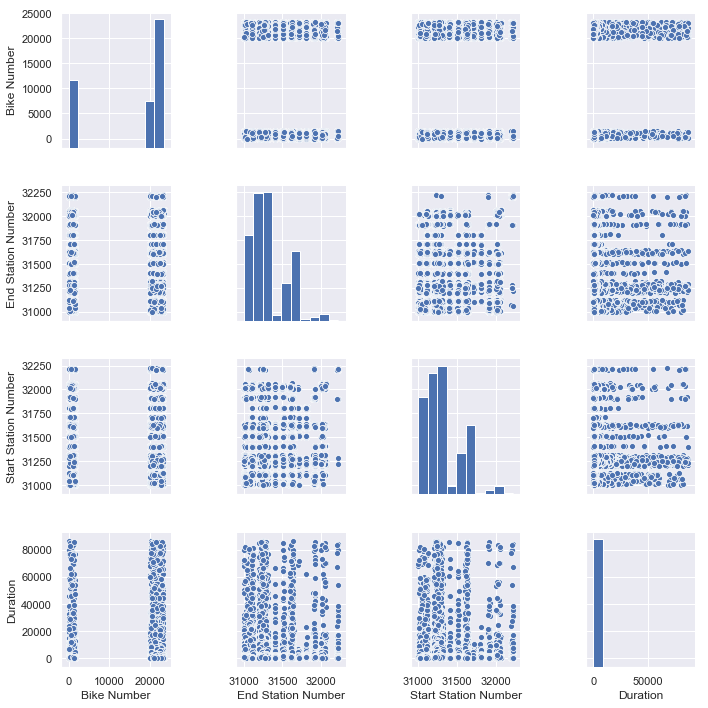

In [37]:
columns = ['Bike Number', 'End Station Number', 'Start Station Number', 'Duration']
sea.pairplot(dataframe_washington[columns])
plt.tight_layout()
plt.show()

In [38]:
columns = ['Bike Number', 'Duration']
bike_duration = dataframe_washington[columns]

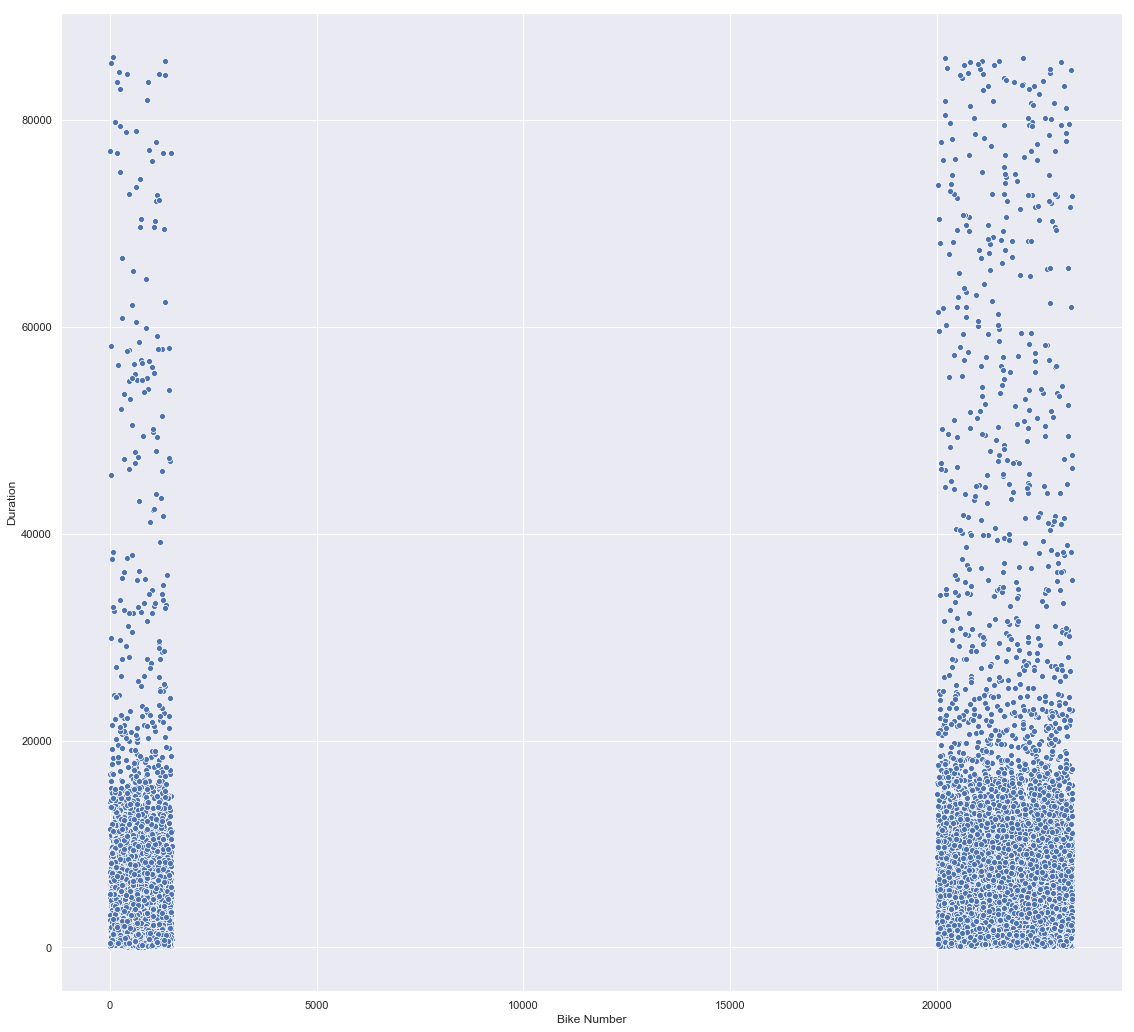

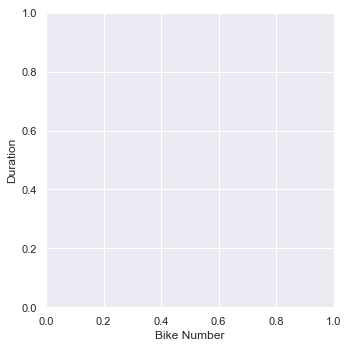

In [39]:
dimensions = (19, 18)
fig, ax = plt.subplots(figsize=dimensions)
sea.relplot(x='Bike Number', y='Duration',
            data=bike_duration, ax=ax);

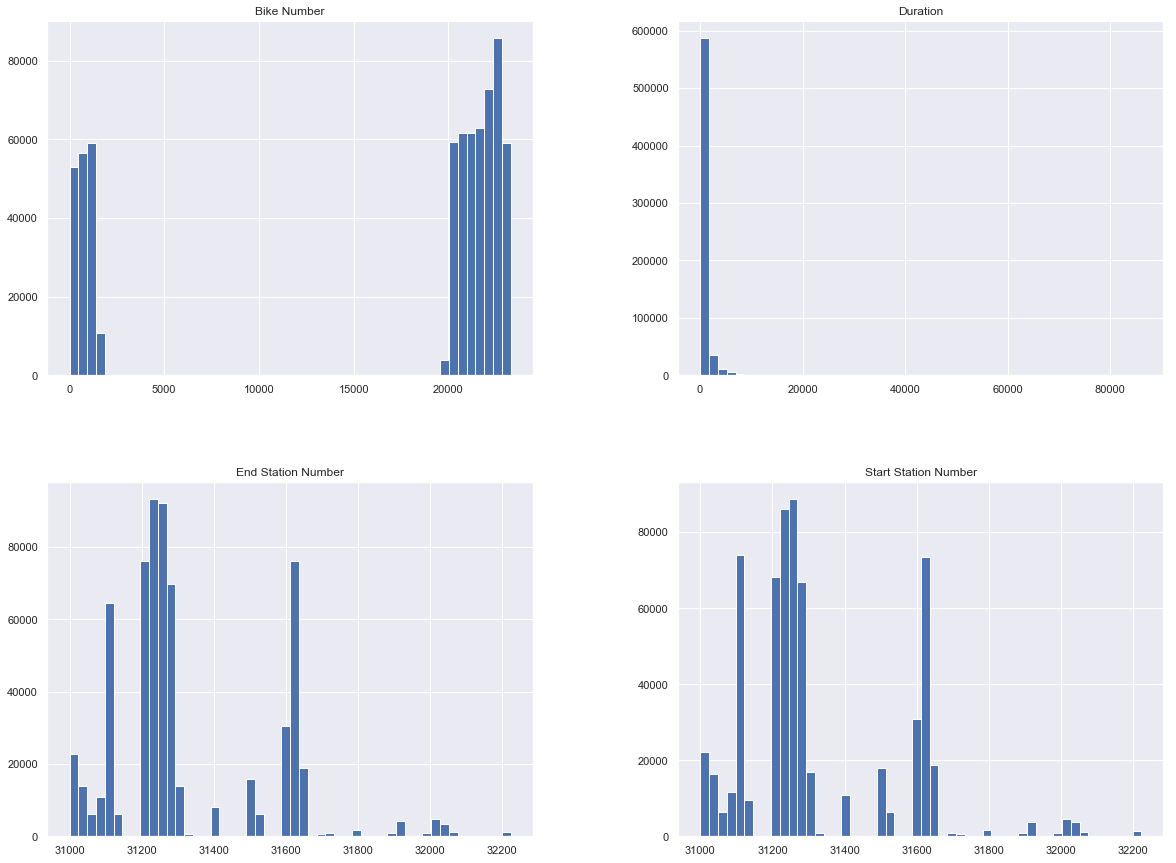

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
dataframe_washington.hist(bins=50, figsize=(20, 15))
plt.show()

In [115]:
# Creating a test set, we will develop a function to do this for us:
def train_test(data, test_ratio):
    np.random.seed(42)
    shuffled = np.random.permutation(len(data))
    testset_size = int(len(data) * test_ratio)
    test_indices = shuffled[:testset_size]
    train_indices = shuffled[testset_size]
    return dataframe_washington.iloc[train_indices], dataframe_washington.iloc[test_indices]

In [116]:
train_set, test_set = train_test(dataframe_washington, 0.2)

In [117]:
len(train_set)

9

In [118]:
len(test_set)

129302

## We can run some basic regression techniques on the data like RMSE (Root Mean Squared Error)

In [130]:
from zlib import crc32

In [131]:
# We create the crc32 hash of each instances identifier.
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [132]:
# This function splits the data into test set and training set according to an id
def train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [133]:
# We create a new index column from 0 to n = size of dataset.
by_id = dataframe_washington.reset_index()

In [134]:
train_set_v2, test_set_v2 = train_test_by_id(by_id, 0.2, "index")

## The previous train_test splitter method would break if a new dataset was loaded into the notebook, to bypass that problem. A new solution would be the train_test_by_id in which we use each instances identifier to decide wheter or not it should go in the test set. 

In [135]:
len(train_set_v2)

517205

In [136]:
len(test_set_v2)

129305

In [137]:
dataframe_washington.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646510 entries, 0 to 646509
Data columns (total 9 columns):
Duration                646510 non-null int64
Start Date              646510 non-null object
End Date                646510 non-null object
Start Station Number    646510 non-null int64
Start Station Name      646510 non-null object
End Station Number      646510 non-null int64
End Station Name        646510 non-null object
Bike Number             646510 non-null int64
Member Type             646510 non-null object
dtypes: int64(4), object(5)
memory usage: 44.4+ MB


## I would like to visualise the destination of each bike share dock. Our main dataset doesn't have a latitude/longitude column for us to do this, therefore, for this visualisation we will use a temporary dataset of Bike Share docks in Melbourne.

The data can be found here: [Bike Data](https://data.melbourne.vic.gov.au/Transport-Movement/Bike-Share-Dock-Locations/vrwc-rwgm)

In [149]:
%%time
# Load up the journeys.csv dataset into dataframes
dataframe_melbourne = pd.read_csv('data/Bike_Share_Dock_Locations.csv')
dataframe_melbourne.columns = ['station_id', 'Name', 'Rental_Method', 'Capacity', 'Latitude', 'Longitude', 'Location']
dataframe_melbourne.dropna()

CPU times: user 5.88 ms, sys: 2.32 ms, total: 8.2 ms
Wall time: 6.69 ms


In [150]:
dataframe_melbourne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
station_id       50 non-null int64
Name             50 non-null object
Rental_Method    50 non-null object
Capacity         50 non-null int64
Latitude         50 non-null float64
Longitude        50 non-null float64
Location         50 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 2.8+ KB


In [151]:
dataframe_melbourne.head()

,station_id,Name,Rental_Method,Capacity,Latitude,Longitude,Location
0,52,Flagstaff Gardens - Peel St - West Melbourne,"CREDITCARD,KEY",11,-37.809216,144.955223,"(-37.809216, 144.955223)"
1,17,Yarra's Point - Lorimer St / Yarra River - Doc...,"CREDITCARD,KEY",15,-37.823805,144.943051,"(-37.823805, 144.943051)"
2,25,Sandridge Bridge - Southbank,"CREDITCARD,KEY",27,-37.820836,144.962266,"(-37.820836, 144.962266)"
3,39,Richmond Station - Brunton Ave - East Melbourne,"CREDITCARD,KEY",19,-37.822962,144.988507,"(-37.822962, 144.988507)"
4,18,Argyle Square - Lygon St - Carlton,"CREDITCARD,KEY",11,-37.802129,144.966770,"(-37.802129, 144.96677)"


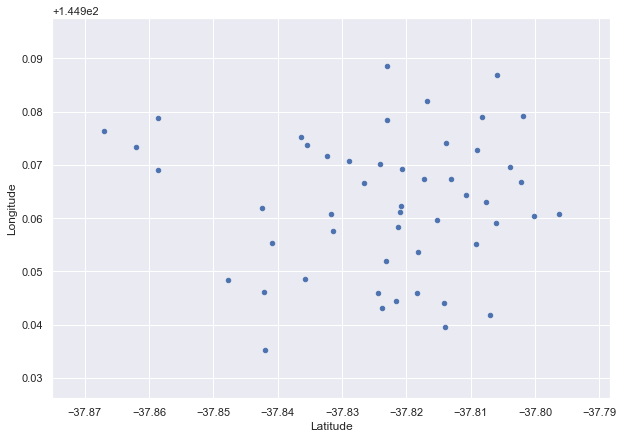

In [159]:
dataframe_melbourne.plot(kind = "scatter", x = "Latitude", y = "Longitude", figsize = (10, 7));

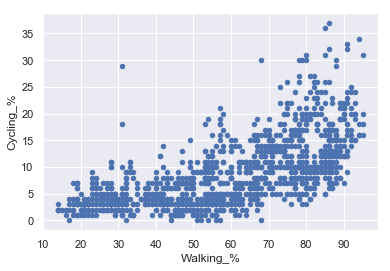

In [160]:
# We can create a scatter of the walking and cycling % of our journeys dataframe (first dataset)
dataframe_journeys.plot(kind = "scatter", x = "Walking_%", y = "Cycling_%")

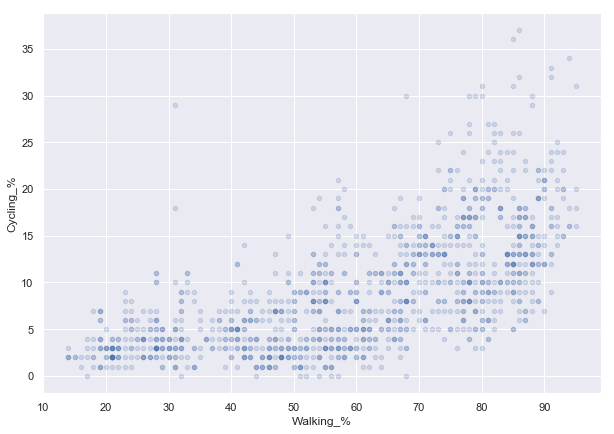

In [162]:
# If we want to see the high density points, we can set alpha to 0.1
dataframe_journeys.plot(kind = "scatter", x = "Walking_%", y = "Cycling_%", alpha = 0.2, figsize = (10, 7))